Individual assignment
===
1. Preprocessing
2. Sanity checks
3. First-level analysis

# 0. Setup

## Imports

In [1]:
import jupyter_black

jupyter_black.load()

In [2]:
import os
from os.path import join as opj
import json
from nipype.interfaces.fsl import (
    BET,
    ExtractROI,
    FAST,
    FLIRT,
    ImageMaths,
    MCFLIRT,
    SliceTimer,
    Threshold,
    IsotropicSmooth,
    FLIRT,
    FNIRT,
    ApplyWarp,
)
from nipype.interfaces.fsl.utils import RobustFOV
import nibabel as nib
from nilearn import image, plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches

# from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node
from IPython.display import Image

# Check if ENV variables are set
print(os.environ["FSLDIR"])
print(os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

# os.environ["LD_LIBRARY_PATH"] = os.environ["LD_LIBRARY_PATH"] + os.pathsep + "/usr/lib/fsl/5.0"

/opt/fsl-5.0.11
NIFTI_GZ


## Download data and MNI atlas

In [3]:
# !gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
# !unzip ./ds000102.zip -d ./data

# add mni template to fsl dir
# os.makedirs(fslpath + "/data/standard", exist_ok=True)
# !wget 'https://ucloud.univie.ac.at/index.php/s/bnj6HPWqImlpFjD/download' -O mniatlas.zip
# !unzip -oq mniatlas.zip -d ${FSLDIR}/data/standard

In [4]:
mni_template = os.path.join(
    os.getenv("FSLDIR"), "data/standard/MNI152_T1_2mm_brain.nii.gz"
)

os.path.exists(mni_template)

True

## Experiment parameters

In [5]:
project_root_dir = os.getcwd()
experiment_dir = project_root_dir + "/output"
output_dir = "datasink"
working_dir = "working_dir"
data_dir = project_root_dir + "/data/ds000102"

# list of subject identifiers
subject_list = ["02"]

# list of session identifiers
task_list = ["flanker"]

# Smoothing widths to apply
fwhm = [4]  # [4, 8]

# TR of functional images
with open(data_dir + "/task-flanker_bold.json", "rt") as fp:
    task_info = json.load(fp)
TR = task_info["RepetitionTime"]

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4


os.environ["FSLOUTPUTTYPE"] = "NIFTI"

os.makedirs("data", exist_ok=True)
os.makedirs("output/working_dir", exist_ok=True)
os.makedirs(fslpath + "/data/standard", exist_ok=True)

### Inspect Data

In [6]:
anat = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/anat/sub-{subject_list[0]}_T1w.nii.gz"
)
func = nib.load(
    f"{data_dir}/sub-{subject_list[0]}/func/sub-{subject_list[0]}_task-flanker_run-1_bold.nii.gz"
)

anat_data = anat.get_fdata()
func_data = func.get_fdata()[:, :, :, 4:]


# check the shape of the files
print("shape of anat file:", anat_data.shape)
print("shape of func file:", func_data.shape)

print(
    f"\nWe have {func_data.shape[2]} slices with a resolution of {func_data.shape[0]}x{func_data.shape[1]} voxels and {func_data.shape[3]} timepoints"
)

shape of anat file: (176, 256, 256)
shape of func file: (64, 64, 40, 142)

We have 40 slices with a resolution of 64x64 voxels and 142 timepoints


In [7]:
TA = TR - (TR / func_data.shape[2])

#### Plot of anatomical image

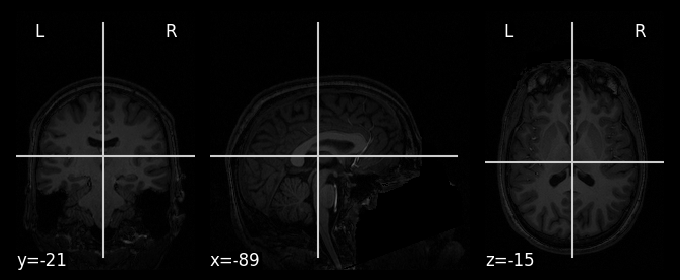

In [8]:
plotting.plot_anat(anat);

#### Plot of functional image

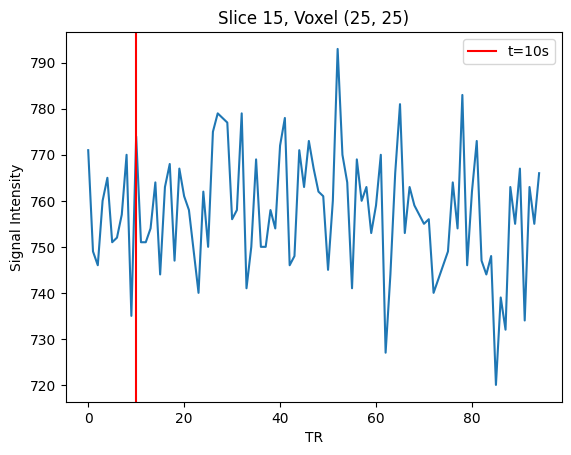

In [9]:
# define variables for number of slices, tr and ta

slice_no = 15
voxel_x = 25
voxel_y = 25

timepoints = slice(5, 100)
timepoint = 10

plt.plot(func_data[slice_no, voxel_x, voxel_y, timepoints])
plt.axvline(timepoint, color="red", label=f"t={timepoint}s")
plt.xlabel("TR")
plt.ylabel("Signal Intensity")
plt.title(f"Slice {slice_no}, Voxel {(voxel_x, voxel_y)}")
plt.legend();

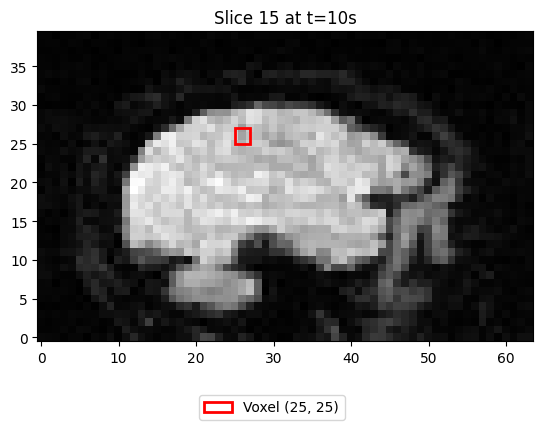

In [10]:
fig, ax = plt.subplots()
ax.imshow(func_data[slice_no, :, :, timepoint].T, cmap="gray", origin="lower")
rect = patches.Rectangle(
    (voxel_x, voxel_y),
    2,
    2,
    linewidth=2,
    edgecolor="r",
    facecolor="none",
    label=f"Voxel {(voxel_x, voxel_y)}",
)
ax.add_patch(rect)
ax.set_title(f"Slice {slice_no} at t={timepoint}s")
fig.legend(loc="lower center");

<div class="alert alert-info">everything looks alright</div>

# 1. Preprocessing

## Nodes for main workflow

In [11]:
# ExtractROI - remove first 4 volumes
# extract = Node(ExtractROI(t_min=4, t_size=-1, output_type="NIFTI"), name="extract")
extract = Node(
    ExtractROI(crop_list=[(0, -1), (0, -1), (0, -1), (4, -1)]), name="extract"
)  # alternative

# MCFLIRT - motion correction
mcflirt = Node(
    MCFLIRT(mean_vol=True, save_plots=True, output_type="NIFTI"), name="mcflirt"
)

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(
    SliceTimer(
        index_dir=False, interleaved=True, output_type="NIFTI", time_repetition=TR
    ),
    name="slicetimer",
)

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(), name="smooth")
# smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(
    ArtifactDetect(
        norm_threshold=2,
        zintensity_threshold=3,
        mask_type="spm_global",
        parameter_source="FSL",
        use_differences=[True, False],
        plot_type="svg",
    ),
    name="art",
)

## Coregistration workflow

221204-20:00:19,596 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/coregwf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/coregwf/graph.png (graph2use=colored, simple_form=True).


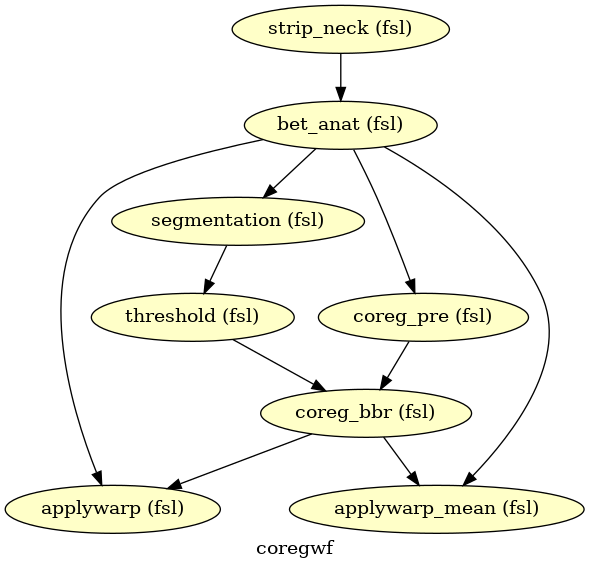

In [23]:
# RobustFOV - Remove neck from anatomical image to improve skullstripping
strip_neck = Node(RobustFOV(), name="strip_neck")

# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5, robust=True, output_type="NIFTI_GZ"), name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type="NIFTI_GZ"), name="segmentation")

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]


# Threshold - Threshold WM probability image
threshold = Node(
    Threshold(thresh=0.5, args="-bin", output_type="NIFTI_GZ"), name="threshold"
)

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type="NIFTI_GZ"), name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(
    FLIRT(
        dof=6,
        cost="bbr",
        schedule=opj(os.getenv("FSLDIR"), "etc/flirtsch/bbr.sch"),
        output_type="NIFTI_GZ",
    ),
    name="coreg_bbr",
)

# Apply coregistration warp to functional images
applywarp = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI"), name="applywarp"
)

# Apply coregistration warp to mean file
applywarp_mean = Node(
    FLIRT(interp="spline", apply_isoxfm=iso_size, output_type="NIFTI_GZ"),
    name="applywarp_mean",
)

# Create a coregistration workflow
coregwf = Workflow(name="coregwf")
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect(
    [
        (strip_neck, bet_anat, [("out_roi", "in_file")]),
        (bet_anat, segmentation, [("out_file", "in_files")]),
        (segmentation, threshold, [(("partial_volume_files", get_wm), "in_file")]),
        (bet_anat, coreg_pre, [("out_file", "reference")]),
        (threshold, coreg_bbr, [("out_file", "wm_seg")]),
        (coreg_pre, coreg_bbr, [("out_matrix_file", "in_matrix_file")]),
        (coreg_bbr, applywarp, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp, [("out_file", "reference")]),
        (coreg_bbr, applywarp_mean, [("out_matrix_file", "in_matrix_file")]),
        (bet_anat, applywarp_mean, [("out_file", "reference")]),
    ]
)

coregwf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coregwf.base_dir, "coregwf", "graph.png"))

Alternative

221204-20:00:21,661 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/coreg_wf/graph.png (graph2use=colored, simple_form=True).


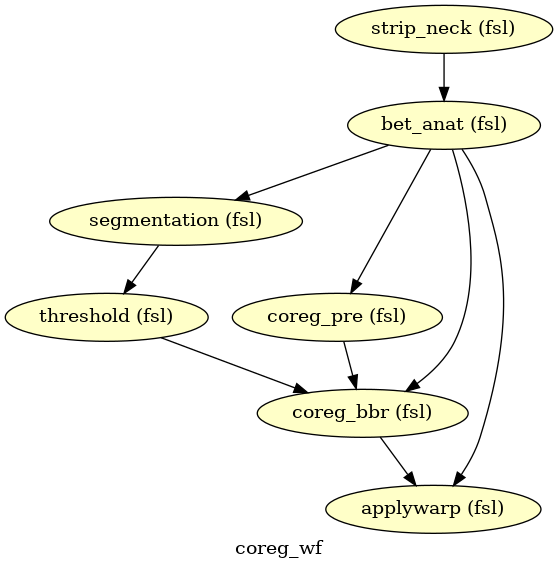

In [24]:
# import custom coregistration and normalization scripts
from fslspatial import create_fsl_coregflow, create_fsl_normflow


coreg_wf = create_fsl_coregflow(
    base_directory=opj(experiment_dir, working_dir), apply_to_epis=True
)

coreg_wf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(coreg_wf.base_dir, "coreg_wf", "graph.png"))

## Normalization workflow

221204-20:00:28,165 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/normwf/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/normwf/graph.png (graph2use=colored, simple_form=True).


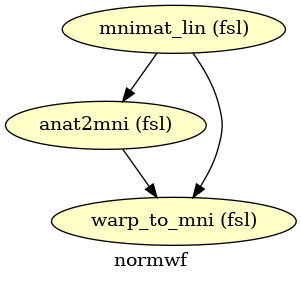

In [25]:
normwf = Workflow(name="normwf", base_dir=opj(experiment_dir, working_dir))

# linear transformation of t1 to mni template
mnimat_lin = Node(
    FLIRT(cost_func="normcorr", dof=12, reference=mni_template), name="mnimat_lin"
)

# non-linear transformation of t1 to mni (using params from linear transf.)
anat2mni = Node(FNIRT(ref_file=mni_template, warped_file="warped.nii"), name="anat2mni")

# warp epi data to mni template
warp_to_mni = Node(ApplyWarp(ref_file=mni_template), name="warp_to_mni")

normwf.connect(
    [
        (mnimat_lin, anat2mni, [("out_matrix_file", "affine_file")]),
        (anat2mni, warp_to_mni, [("field_file", "field_file")]),
        (mnimat_lin, warp_to_mni, [("out_matrix_file", "postmat")]),
    ]
)

normwf.write_graph(graph2use="colored", format="png", simple_form=True)
Image(filename=opj(normwf.base_dir, "normwf", "graph.png"))

## IO stream

In [26]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(
    IdentityInterface(fields=["subject_id", "task_name"]), name="infosource"
)
infosource.iterables = [("subject_id", subject_list), ("task_name", task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj(
    "sub-{subject_id}",
    "anat",
    "sub-{subject_id}_T1w.nii.gz",
)
func_file = opj(
    "sub-{subject_id}",
    "func",
    "sub-{subject_id}_task-{task_name}_run-1_bold.nii.gz",
)

templates = {"anat": anat_file, "func": func_file}
selectfiles = Node(SelectFiles(templates, base_directory=data_dir), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(
    DataSink(base_directory=experiment_dir, container=output_dir), name="datasink"
)

## Use the following DataSink output substitutions
substitutions = [
    ("_subject_id_", "sub-"),
    ("_task_name_", "/task-"),
    ("_fwhm_", "fwhm-"),
    ("_roi", ""),
    ("_mcf", ""),
    ("_st", ""),
    ("_flirt", ""),
    (".nii_mean_reg", "_mean"),
    (".nii.par", ".par"),
]
subjFolders = [("fwhm-%s/" % f, "fwhm-%s_" % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Connect main workflow

In [34]:
# Create a preprocessing workflow
preproc = Workflow(name="preproc")
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect(
    [
        (
            infosource,
            selectfiles,
            [("subject_id", "subject_id"), ("task_name", "task_name")],
        ),
        (selectfiles, extract, [("func", "in_file")]),
        (extract, mcflirt, [("roi_file", "in_file")]),
        (mcflirt, slicetimer, [("out_file", "in_file")]),
        (
            selectfiles,
            coreg_wf,  # coregwf,
            [
                ("anat", "strip_neck.in_file"),
                # ("anat", "coreg_bbr.reference")
            ],
        ),
        (
            mcflirt,
            coreg_wf,  #   coregwf,
            [
                ("mean_img", "coreg_pre.in_file"),
                ("mean_img", "coreg_bbr.in_file"),
                #      ("mean_img", "applywarp_mean.in_file"),
            ],
        ),
        (
            slicetimer,
            coreg_wf,  # coregwf,
            [("slice_time_corrected_file", "applywarp.in_file")],
        ),
        (
            coreg_wf,  # coregwf,
            normwf,
            [
                ("segmentation.restored_image", "mnimat_lin.in_file"),
                ("segmentation.restored_image", "anat2mni.in_file"),
                ("applywarp.out_file", "warp_to_mni.in_file"),
            ],
        ),
        (normwf, smooth, [("warp_to_mni.out_file", "in_file")]),
        (mcflirt, datasink, [("par_file", "preproc.@par")]),
        (smooth, datasink, [("out_file", "preproc.@smooth")]),
        # (coregwf,
        # datasink, [("applywarp_mean.out_file", "preproc.@mean")]),
        (coreg_wf, art, [("applywarp.out_file", "realigned_files")]),  # coregwf,
        (mcflirt, art, [("par_file", "realignment_parameters")]),
        (
            coreg_wf,  # coregwf,
            datasink,
            [
                ("coreg_bbr.out_matrix_file", "preproc.@mat_file"),
                ("bet_anat.out_file", "preproc.@brain"),
            ],
        ),
        (
            normwf,
            datasink,
            [
                ("warp_to_mni.out_file", "datasink.@warped_to_mni"),
                ("anat2mni.warped_file", "datasink.@_file"),
            ],
        ),
        (
            art,
            datasink,
            [
                ("outlier_files", "preproc.@outlier_files"),
                ("plot_files", "preproc.@plot_files"),
            ],
        ),
    ]
)

## Visualize the complete workflow

221204-20:07:10,548 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/preproc/graph.png (graph2use=colored, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/preproc/graph.png (graph2use=colored, simple_form=True).


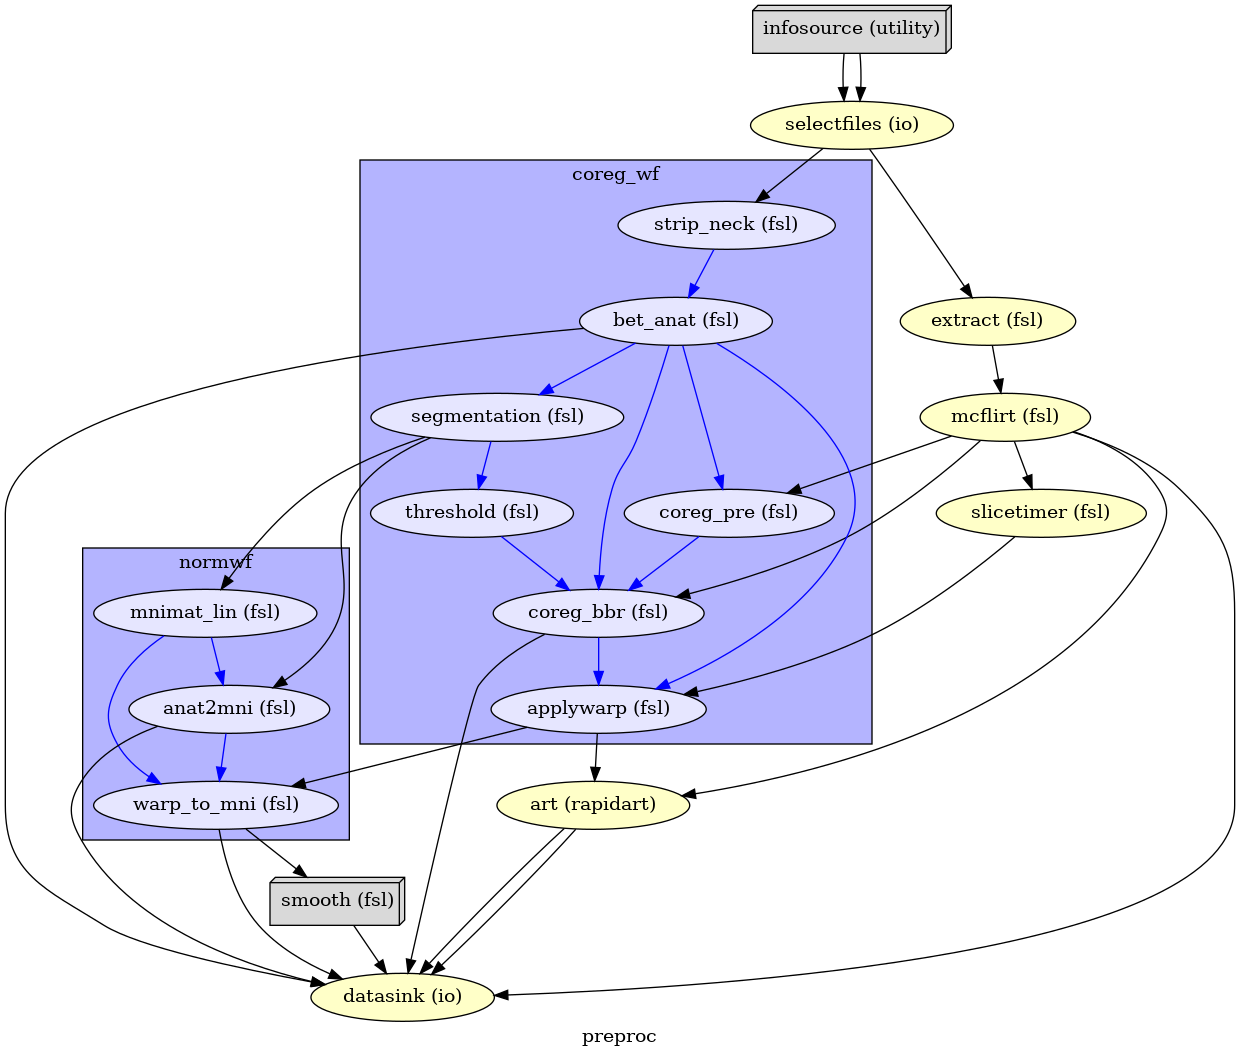

In [29]:
# Create preproc output graph
preproc.write_graph(graph2use="colored", format="png", simple_form=True)

Image(filename=opj(preproc.base_dir, "preproc", "graph.png"))

221204-20:07:37,641 nipype.workflow INFO:
	 Generated workflow graph: /work/assignments/output/working_dir/preproc/graph.png (graph2use=flat, simple_form=True).


INFO:nipype.workflow:Generated workflow graph: /work/assignments/output/working_dir/preproc/graph.png (graph2use=flat, simple_form=True).


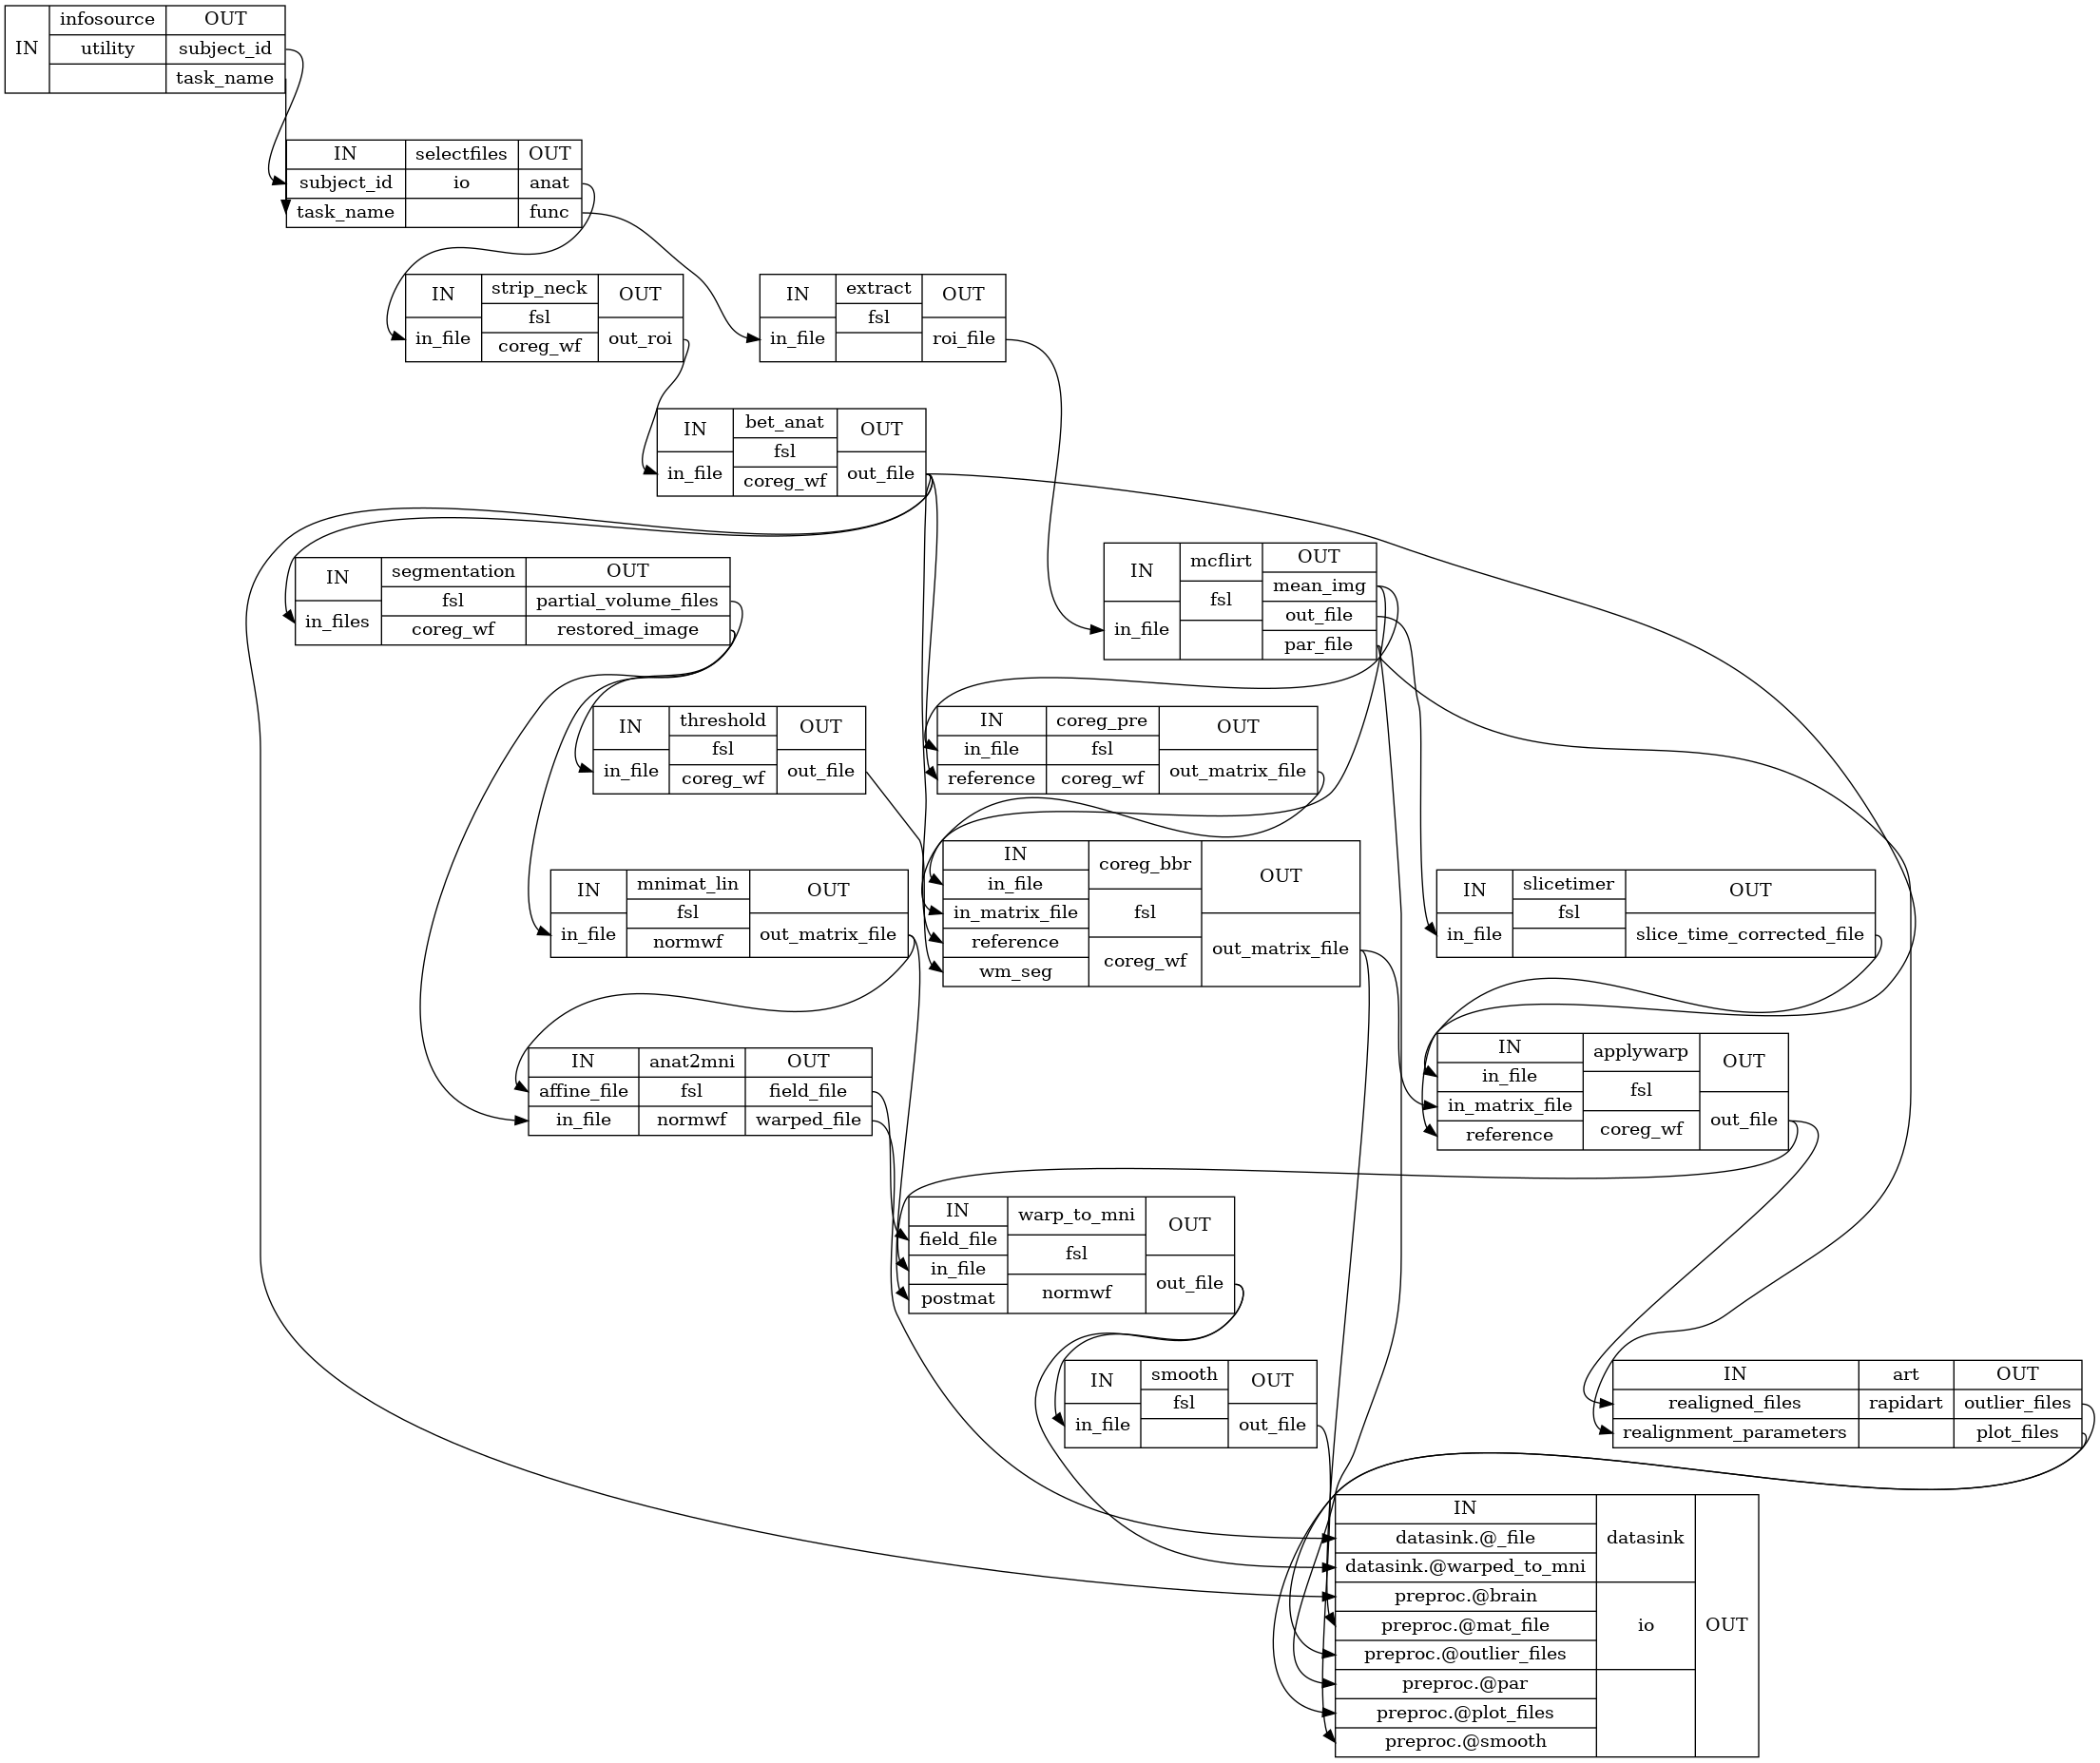

In [30]:
# Visualize the detailed graph
preproc.write_graph(graph2use="flat", format="png", simple_form=True)
Image(filename=opj(preproc.base_dir, "preproc", "graph_detailed.png"))

## Run workflow

In [31]:
preproc.run("MultiProc", plugin_args={"n_procs": 8})

221204-20:07:41,246 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


INFO:nipype.workflow:Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']


221204-20:07:41,273 nipype.workflow INFO:
	 Running in parallel.


INFO:nipype.workflow:Running in parallel.


221204-20:07:41,277 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:07:41,497 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/selectfiles".


INFO:nipype.workflow:[Node] Setting-up "preproc.selectfiles" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/selectfiles".


221204-20:07:41,506 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


INFO:nipype.workflow:[Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>


221204-20:07:41,513 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.001738s.


INFO:nipype.workflow:[Node] Finished "selectfiles", elapsed time 0.001738s.


221204-20:07:43,280 nipype.workflow INFO:
	 [Job 0] Completed (preproc.selectfiles).


INFO:nipype.workflow:[Job 0] Completed (preproc.selectfiles).


221204-20:07:43,286 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:07:43,428 nipype.workflow INFO:
	 [Job 1] Cached (preproc.extract).


INFO:nipype.workflow:[Job 1] Cached (preproc.extract).


221204-20:07:43,437 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.strip_neck" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.strip_neck" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/strip_neck".


221204-20:07:43,449 nipype.workflow INFO:
	 [Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


INFO:nipype.workflow:[Node] Executing "strip_neck" <nipype.interfaces.fsl.utils.RobustFOV>


221204-20:07:44,701 nipype.workflow INFO:
	 [Node] Finished "strip_neck", elapsed time 1.247269s.


INFO:nipype.workflow:[Node] Finished "strip_neck", elapsed time 1.247269s.


221204-20:07:45,283 nipype.workflow INFO:
	 [Job 2] Completed (preproc.coreg_wf.strip_neck).


INFO:nipype.workflow:[Job 2] Completed (preproc.coreg_wf.strip_neck).


221204-20:07:45,293 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:07:45,407 nipype.workflow INFO:
	 [Job 3] Cached (preproc.mcflirt).


INFO:nipype.workflow:[Job 3] Cached (preproc.mcflirt).


221204-20:07:45,417 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.bet_anat" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/bet_anat".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.bet_anat" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/bet_anat".


221204-20:07:45,429 nipype.workflow INFO:
	 [Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


INFO:nipype.workflow:[Node] Executing "bet_anat" <nipype.interfaces.fsl.preprocess.BET>


221204-20:07:47,282 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.bet_anat


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.bet_anat


221204-20:07:47,372 nipype.workflow INFO:
	 [Job 5] Cached (preproc.slicetimer).


INFO:nipype.workflow:[Job 5] Cached (preproc.slicetimer).


221204-20:07:47,998 nipype.workflow INFO:
	 [Node] Finished "bet_anat", elapsed time 2.564521s.


INFO:nipype.workflow:[Node] Finished "bet_anat", elapsed time 2.564521s.


221204-20:07:49,286 nipype.workflow INFO:
	 [Job 4] Completed (preproc.coreg_wf.bet_anat).


INFO:nipype.workflow:[Job 4] Completed (preproc.coreg_wf.bet_anat).


221204-20:07:49,296 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:07:49,413 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.segmentation" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/segmentation".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.segmentation" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/segmentation".


221204-20:07:49,415 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.coreg_pre" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/coreg_pre".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.coreg_pre" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/coreg_pre".


221204-20:07:49,427 nipype.workflow INFO:
	 [Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


INFO:nipype.workflow:[Node] Executing "segmentation" <nipype.interfaces.fsl.preprocess.FAST>


221204-20:07:49,432 nipype.workflow INFO:
	 [Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "coreg_pre" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-20:07:51,285 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 9.65/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_pre
                       * preproc.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 9.65/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_pre
                       * preproc.coreg_wf.segmentation


221204-20:07:54,616 nipype.workflow INFO:
	 [Node] Finished "coreg_pre", elapsed time 5.177457s.


INFO:nipype.workflow:[Node] Finished "coreg_pre", elapsed time 5.177457s.


221204-20:07:55,288 nipype.workflow INFO:
	 [Job 7] Completed (preproc.coreg_wf.coreg_pre).


INFO:nipype.workflow:[Job 7] Completed (preproc.coreg_wf.coreg_pre).


221204-20:07:55,291 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 9.85/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.segmentation


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 9.85/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.segmentation


221204-20:11:17,770 nipype.workflow INFO:
	 [Node] Finished "segmentation", elapsed time 208.338115s.


INFO:nipype.workflow:[Node] Finished "segmentation", elapsed time 208.338115s.


221204-20:11:19,464 nipype.workflow INFO:
	 [Job 6] Completed (preproc.coreg_wf.segmentation).


INFO:nipype.workflow:[Job 6] Completed (preproc.coreg_wf.segmentation).


221204-20:11:19,468 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:11:19,569 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.threshold" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/threshold".
221204-20:11:19,571 nipype.workflow INFO:
	 [Node] Setting-up "preproc.normwf.mnimat_lin" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/mnimat_lin".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.threshold" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/threshold".
INFO:nipype.workflow:[Node] Setting-up "preproc.normwf.mnimat_lin" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/mnimat_lin".


221204-20:11:19,648 nipype.workflow INFO:
	 [Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


INFO:nipype.workflow:[Node] Executing "threshold" <nipype.interfaces.fsl.maths.Threshold>


221204-20:11:19,657 nipype.workflow INFO:
	 [Node] Executing "mnimat_lin" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "mnimat_lin" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-20:11:20,391 nipype.workflow INFO:
	 [Node] Finished "threshold", elapsed time 0.73278s.


INFO:nipype.workflow:[Node] Finished "threshold", elapsed time 0.73278s.


221204-20:11:21,465 nipype.workflow INFO:
	 [Job 8] Completed (preproc.coreg_wf.threshold).


INFO:nipype.workflow:[Job 8] Completed (preproc.coreg_wf.threshold).


221204-20:11:21,468 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.mnimat_lin


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.mnimat_lin


221204-20:11:21,558 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.coreg_bbr" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/coreg_bbr".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.coreg_bbr" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/coreg_bbr".


221204-20:11:21,572 nipype.workflow INFO:
	 [Node] Executing "coreg_bbr" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "coreg_bbr" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-20:11:23,468 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_bbr
                       * preproc.normwf.mnimat_lin


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_bbr
                       * preproc.normwf.mnimat_lin


221204-20:11:50,434 nipype.workflow INFO:
	 [Node] Finished "mnimat_lin", elapsed time 30.764426s.


INFO:nipype.workflow:[Node] Finished "mnimat_lin", elapsed time 30.764426s.


221204-20:11:51,491 nipype.workflow INFO:
	 [Job 9] Completed (preproc.normwf.mnimat_lin).


INFO:nipype.workflow:[Job 9] Completed (preproc.normwf.mnimat_lin).


221204-20:11:51,496 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_bbr


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.coreg_wf.coreg_bbr


221204-20:11:51,583 nipype.workflow INFO:
	 [Node] Setting-up "preproc.normwf.anat2mni" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/anat2mni".


INFO:nipype.workflow:[Node] Setting-up "preproc.normwf.anat2mni" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/anat2mni".


221204-20:11:51,593 nipype.workflow INFO:
	 [Node] Executing "anat2mni" <nipype.interfaces.fsl.preprocess.FNIRT>


INFO:nipype.workflow:[Node] Executing "anat2mni" <nipype.interfaces.fsl.preprocess.FNIRT>


221204-20:11:53,494 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.normwf.anat2mni
                       * preproc.coreg_wf.coreg_bbr


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.normwf.anat2mni
                       * preproc.coreg_wf.coreg_bbr


221204-20:13:34,291 nipype.workflow INFO:
	 [Node] Finished "coreg_bbr", elapsed time 132.71418s.


INFO:nipype.workflow:[Node] Finished "coreg_bbr", elapsed time 132.71418s.


221204-20:13:35,581 nipype.workflow INFO:
	 [Job 10] Completed (preproc.coreg_wf.coreg_bbr).


INFO:nipype.workflow:[Job 10] Completed (preproc.coreg_wf.coreg_bbr).


221204-20:13:35,584 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


221204-20:13:35,677 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coreg_wf.applywarp" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/applywarp".


INFO:nipype.workflow:[Node] Setting-up "preproc.coreg_wf.applywarp" in "/work/assignments/output/working_dir/preproc/coreg_wf/_subject_id_02_task_name_flanker/applywarp".


221204-20:13:35,685 nipype.workflow INFO:
	 [Node] Executing "applywarp" <nipype.interfaces.fsl.preprocess.FLIRT>


INFO:nipype.workflow:[Node] Executing "applywarp" <nipype.interfaces.fsl.preprocess.FLIRT>


221204-20:13:37,584 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.applywarp
                       * preproc.normwf.anat2mni


INFO:nipype.workflow:[MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 13.45/13.85, Free processors: 6/8.
                     Currently running:
                       * preproc.coreg_wf.applywarp
                       * preproc.normwf.anat2mni


221204-20:13:45,447 nipype.workflow INFO:
	 [Node] Finished "applywarp", elapsed time 9.758729s.


INFO:nipype.workflow:[Node] Finished "applywarp", elapsed time 9.758729s.


221204-20:13:45,588 nipype.workflow INFO:
	 [Job 12] Completed (preproc.coreg_wf.applywarp).


INFO:nipype.workflow:[Job 12] Completed (preproc.coreg_wf.applywarp).


221204-20:13:45,590 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


221204-20:13:45,681 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/art".


INFO:nipype.workflow:[Node] Setting-up "preproc.art" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/art".


221204-20:13:45,688 nipype.workflow INFO:
	 [Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>


INFO:nipype.workflow:[Node] Executing "art" <nipype.algorithms.rapidart.ArtifactDetect>


221204-20:13:46,116 nipype.workflow INFO:
	 [Node] Finished "art", elapsed time 0.423056s.


INFO:nipype.workflow:[Node] Finished "art", elapsed time 0.423056s.


221204-20:13:47,590 nipype.workflow INFO:
	 [Job 13] Completed (preproc.art).


INFO:nipype.workflow:[Job 13] Completed (preproc.art).


221204-20:13:47,593 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.anat2mni


221204-20:15:47,40 nipype.workflow INFO:
	 [Node] Finished "anat2mni", elapsed time 235.442237s.


INFO:nipype.workflow:[Node] Finished "anat2mni", elapsed time 235.442237s.


221204-20:15:47,690 nipype.workflow INFO:
	 [Job 11] Completed (preproc.normwf.anat2mni).


INFO:nipype.workflow:[Job 11] Completed (preproc.normwf.anat2mni).


221204-20:15:47,699 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:15:47,799 nipype.workflow INFO:
	 [Node] Setting-up "preproc.normwf.warp_to_mni" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/warp_to_mni".


INFO:nipype.workflow:[Node] Setting-up "preproc.normwf.warp_to_mni" in "/work/assignments/output/working_dir/preproc/normwf/_subject_id_02_task_name_flanker/warp_to_mni".


221204-20:15:47,810 nipype.workflow INFO:
	 [Node] Executing "warp_to_mni" <nipype.interfaces.fsl.preprocess.ApplyWarp>


INFO:nipype.workflow:[Node] Executing "warp_to_mni" <nipype.interfaces.fsl.preprocess.ApplyWarp>


221204-20:15:49,692 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.warp_to_mni


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.normwf.warp_to_mni


221204-20:16:08,617 nipype.workflow INFO:
	 [Node] Finished "warp_to_mni", elapsed time 20.802602s.


INFO:nipype.workflow:[Node] Finished "warp_to_mni", elapsed time 20.802602s.


221204-20:16:09,707 nipype.workflow INFO:
	 [Job 14] Completed (preproc.normwf.warp_to_mni).


INFO:nipype.workflow:[Job 14] Completed (preproc.normwf.warp_to_mni).


221204-20:16:09,710 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:16:09,835 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/_fwhm_4/smooth".


INFO:nipype.workflow:[Node] Setting-up "preproc.smooth" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/_fwhm_4/smooth".


221204-20:16:09,842 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.fsl.maths.IsotropicSmooth>


INFO:nipype.workflow:[Node] Executing "smooth" <nipype.interfaces.fsl.maths.IsotropicSmooth>


221204-20:16:11,708 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.smooth


INFO:nipype.workflow:[MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.65/13.85, Free processors: 7/8.
                     Currently running:
                       * preproc.smooth


221204-20:16:44,252 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 34.404929s.


INFO:nipype.workflow:[Node] Finished "smooth", elapsed time 34.404929s.


221204-20:16:45,738 nipype.workflow INFO:
	 [Job 15] Completed (preproc.smooth).


INFO:nipype.workflow:[Job 15] Completed (preproc.smooth).


221204-20:16:45,745 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


221204-20:16:45,858 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/_fwhm_4/datasink".


INFO:nipype.workflow:[Node] Setting-up "preproc.datasink" in "/work/assignments/output/working_dir/preproc/_subject_id_02_task_name_flanker/_fwhm_4/datasink".


221204-20:16:45,940 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>


INFO:nipype.workflow:[Node] Executing "datasink" <nipype.interfaces.io.DataSink>


221204-20:16:45,951 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii.par -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii.par -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par


221204-20:16:45,960 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/art.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_outliers.txt -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/art.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_outliers.txt -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt


221204-20:16:45,966 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/plot.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt.svg -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/plot.sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt.svg -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg


221204-20:16:45,973 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii_mean_reg_flirt.mat -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_mean.mat


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf.nii_mean_reg_flirt.mat -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_mean.mat


221204-20:16:45,976 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_T1w_ROI_brain.nii.gz -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_T1w_ROI_brain.nii.gz


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/sub-02_T1w_ROI_brain.nii.gz -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/sub-02_T1w_ROI_brain.nii.gz


221204-20:16:45,979 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/datasink/_subject_id_02_task_name_flanker/warped.nii -> /work/assignments/output/datasink/datasink/sub-02/task-flanker/warped.nii


INFO:nipype.interface:sub: /work/assignments/output/datasink/datasink/_subject_id_02_task_name_flanker/warped.nii -> /work/assignments/output/datasink/datasink/sub-02/task-flanker/warped.nii


221204-20:16:45,982 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/datasink/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /work/assignments/output/datasink/datasink/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii


INFO:nipype.interface:sub: /work/assignments/output/datasink/datasink/_subject_id_02_task_name_flanker/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp.nii -> /work/assignments/output/datasink/datasink/sub-02/task-flanker/sub-02_task-flanker_run-1_bold_warp.nii


221204-20:16:45,986 nipype.interface INFO:
	 sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/_fwhm_4/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp_smooth.nii -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/fwhm-4_sub-02_task-flanker_run-1_bold_warp_smooth.nii


INFO:nipype.interface:sub: /work/assignments/output/datasink/preproc/_subject_id_02_task_name_flanker/_fwhm_4/sub-02_task-flanker_run-1_bold_roi_mcf_st_flirt_warp_smooth.nii -> /work/assignments/output/datasink/preproc/sub-02/task-flanker/fwhm-4_sub-02_task-flanker_run-1_bold_warp_smooth.nii


221204-20:16:45,991 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.040544s.


INFO:nipype.workflow:[Node] Finished "datasink", elapsed time 0.040544s.


221204-20:16:47,740 nipype.workflow INFO:
	 [Job 16] Completed (preproc.datasink).


INFO:nipype.workflow:[Job 16] Completed (preproc.datasink).


221204-20:16:47,753 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


INFO:nipype.workflow:[MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.85/13.85, Free processors: 8/8.


# 2. Sanity checks

## Inspect output

In [41]:
!tree output/datasink

output/datasink
├── datasink
│   └── sub-02
│       └── task-flanker
│           ├── sub-02_task-flanker_run-1_bold_warp.nii
│           └── warped.nii
└── preproc
    └── sub-02
        └── task-flanker
            ├── art.sub-02_task-flanker_run-1_bold_outliers.txt
            ├── fwhm-4_sub-02_task-flanker_run-1_bold_warp_smooth.nii
            ├── plot.sub-02_task-flanker_run-1_bold.svg
            ├── sub-02_T1w_ROI_brain.nii.gz
            ├── sub-02_task-flanker_run-1_bold.par
            └── sub-02_task-flanker_run-1_bold_mean.mat

6 directories, 8 files


<div class="alert alert-warning">Unfortunately, it seems that one of the subworkflows doesn't store their files in the mainworkflow directory, but instead creates another datasink folder.</div>

## Visualize results

Anatomical image

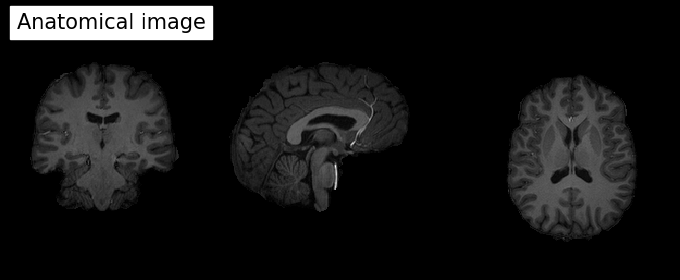

In [42]:
#%matplotlib inline
out_path = f"output/datasink/preproc/sub-{subject_list[0]}/task-flanker"

plotting.plot_epi(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz"),
    title="Anatomical image",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

Functional image, Mean activation

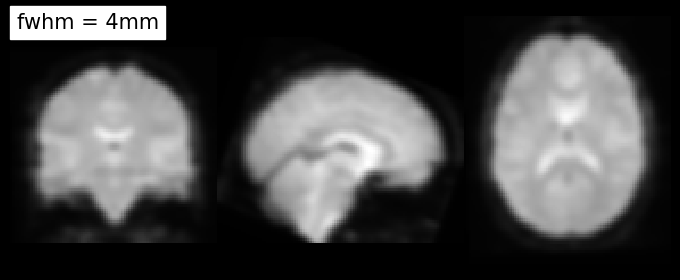

In [44]:
plotting.plot_epi(
    image.mean_img(
        opj(
            out_path,
            f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
        )
    ),
    title="fwhm = 4mm",
    display_mode="ortho",
    annotate=False,
    draw_cross=False,
    cmap="gray",
);

## Check shape of preprocessed image

In [54]:
pp_anat = nib.load(
    opj(out_path, f"sub-{subject_list[0]}_T1w_ROI_brain.nii.gz")
).get_fdata()

print(f"\n Shape of anatomical image: {pp_anat.shape}")


 Shape of anatomical image: (176, 256, 170)


In [55]:
pp_func = nib.load(
    opj(
        out_path,
        f"fwhm-4_sub-{subject_list[0]}_task-flanker_run-1_bold_warp_smooth.nii",
    )
).get_fdata()

print(f"\n Shape of functional image: {pp_func.shape}")


 Shape of functional image: (91, 109, 91, 142)


## Motion

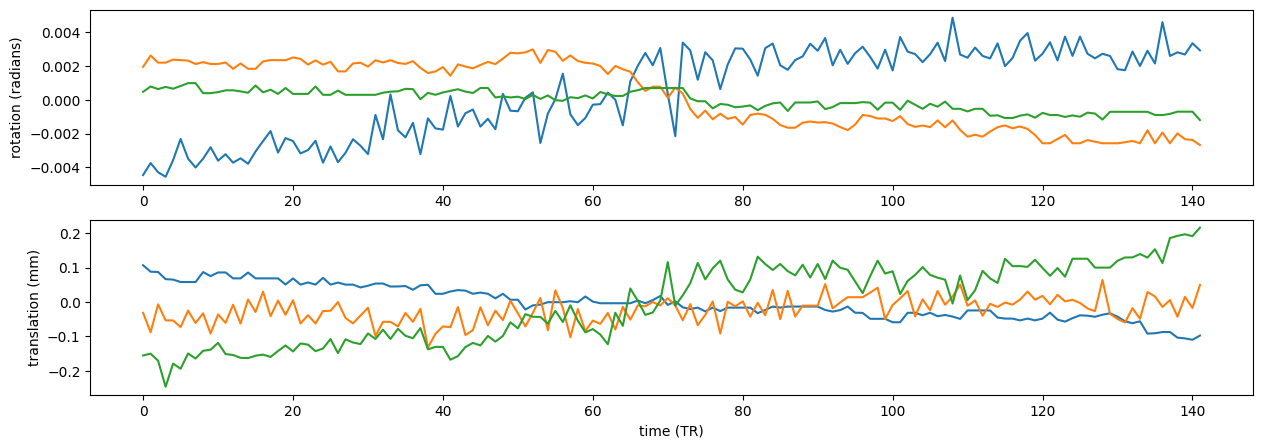

In [56]:
par = np.loadtxt(
    "output/datasink/preproc/sub-02/task-flanker/sub-02_task-flanker_run-1_bold.par"
)
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel("rotation (radians)")
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel("time (TR)")
axes[1].set_ylabel("translation (mm)");

<div class="alert alert-info">Seems to be an outlier at around volume 75 on the x-axis (rotation)</div>

Outliers were detected at volumes: [0. 1. 2. 3.]


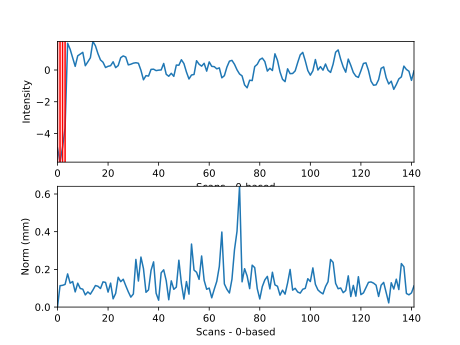

In [57]:
outlier_ids = np.loadtxt(
    "output/datasink/preproc/sub-02/task-flanker/art.sub-02_task-flanker_run-1_bold_outliers.txt"
)
print("Outliers were detected at volumes: %s" % outlier_ids)

from IPython.display import SVG

SVG(
    filename="output/datasink/preproc/sub-02/task-flanker/plot.sub-02_task-flanker_run-1_bold.svg"
)

## Check normalization

Visualize normalization results by overlaying raw and normalized files with MNI template mask

In [32]:
#
#
#

# 3. First Level Analysis

Using the preprocessed files, perform a first-level analysis. The steps are:

- Setup Model (using Nilearn's ```FirstLevelModel```)

- Fit the model to the data
  - use the events file stored in the data directory
  - use the motion parameter as confounds
  
  
- Plot the design matrix
- Define the contrasts
  - congruent_correct > baseline
  - incongruent_correct > baseline
  - incongruent-congruent
  - congruent-incongruent
  - motion parameters > baseline
- Calculate a z-statistics map for each contrast
- Plot the z-statistics maps (using the subject's warped anatomical image as background)

In [33]:
#
#
#